<a href="https://colab.research.google.com/github/bharani195/Liver_Disease_prediction/blob/main/Final_123_Liver_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00


100%|██████████| 7/7 [00:00<00:00, 50.97it/s]


Selected features for modeling: ['Total Protiens', 'A/G Ratio Albumin and Globulin Ratio', '\xa0Sgpt Alamine Aminotransferase', 'Age of the patient', 'Gender of the patient', 'Total Bilirubin', 'Sgot Aspartate Aminotransferase', '\xa0Alkphos Alkaline Phosphotase', 'Direct Bilirubin', '\xa0ALB Albumin']
Training KNN...
KNN - Accuracy: 0.7778, F1: 0.7500, ROC-AUC: 0.8302469135802469
Training SVM...
SVM - Accuracy: 0.9167, F1: 0.9091, ROC-AUC: 0.9598765432098765
Training MLP...
MLP - Accuracy: 0.9722, F1: 0.9714, ROC-AUC: 0.9753086419753086
Training RandomForest...
RandomForest - Accuracy: 0.8333, F1: 0.8125, ROC-AUC: 0.8734567901234568
Training XGBoost...
XGBoost - Accuracy: 0.8611, F1: 0.8485, ROC-AUC: 0.8734567901234568
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72, number of negative: 72
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.


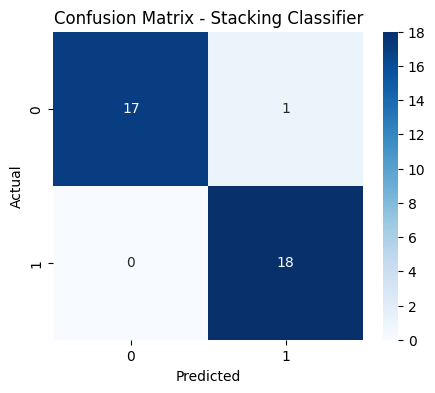


Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      1.00      0.97        18

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



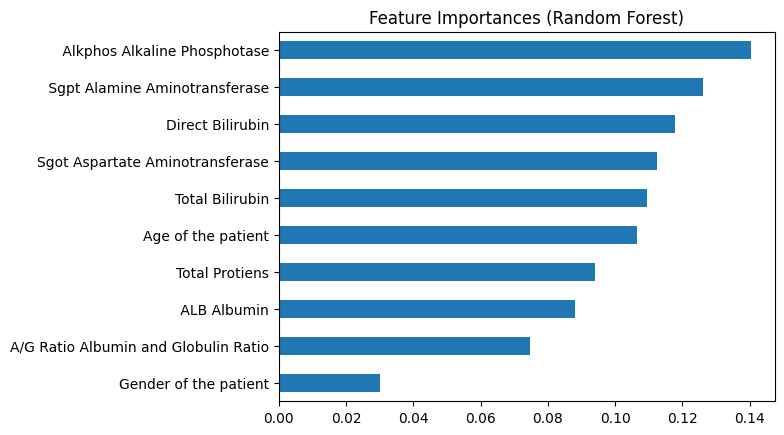

In [2]:
# 1. Mount Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTE

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# **Add the try-except block here:**
try:
    from catboost import CatBoostClassifier
except ImportError:
    !pip install catboost
    from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 2. Load your real-time dataset
file_path = '/content/drive/MyDrive/Research project/123-Real-Time_DataSet.xlsx - Sheet1.csv'
df = pd.read_csv(file_path)

# ... (rest of your code) ...

# 3. Data Preprocessing
# -- Identify target column (assume last column is target, adjust if needed)
target_col = df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

# -- Encode categorical features
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# -- Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# -- Feature Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# 4. Advanced Feature Selection (Boruta, LASSO, mRMR, ANOVA, MI)
# -- You may need to pip install boruta and mrmr_selection if not available
try:
    from boruta import BorutaPy
except ImportError:
    !pip install boruta
    from boruta import BorutaPy

try:
    from mrmr import mrmr_classif
except ImportError:
    !pip install mrmr_selection
    from mrmr import mrmr_classif

# -- Boruta
rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', random_state=42)
boruta_selector.fit(X_scaled.values, y.values)
boruta_features = X.columns[boruta_selector.support_].tolist()

# -- LASSO
from sklearn.linear_model import LogisticRegression
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso.fit(X_scaled, y)
lasso_features = X.columns[np.abs(lasso.coef_[0]) > 1e-5].tolist()

# -- mRMR
mrmr_features = mrmr_classif(X_scaled, y, K=7)

# -- ANOVA F-test and Mutual Information
anova_selector = SelectKBest(score_func=f_classif, k=7).fit(X_scaled, y)
anova_features = X.columns[anova_selector.get_support()].tolist()
mi_selector = SelectKBest(score_func=mutual_info_classif, k=7).fit(X_scaled, y)
mi_features = X.columns[mi_selector.get_support()].tolist()

# -- Combine all selected features (union)
selected_features = list(set(boruta_features + lasso_features + mrmr_features + anova_features + mi_features))
print("Selected features for modeling:", selected_features)

X_selected = X_scaled[selected_features]

# 5. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_selected, y)

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# 7. Model Definitions & Hyperparameter Optimization (RandomizedSearchCV)
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'ExtraTrees': ExtraTreesClassifier()
}

params = {
    'KNN': {'n_neighbors': [3,5,7,9]},
    'SVM': {'C': [0.1,1,10], 'kernel': ['rbf','linear']},
    'MLP': {'hidden_layer_sizes': [(50,50),(100,)], 'activation': ['relu','tanh']},
    'RandomForest': {'n_estimators': [100,200], 'max_depth': [None,10,20]},
    'XGBoost': {'n_estimators': [100,200], 'max_depth': [3,5,7]},
    'LightGBM': {'n_estimators': [100,200], 'max_depth': [-1,10,20]},
    'CatBoost': {'iterations': [100,200], 'depth': [4,6,8]},
    'ExtraTrees': {'n_estimators': [100,200], 'max_depth': [None,10,20]}
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    search = RandomizedSearchCV(model, params[name], n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:,1] if hasattr(search, 'predict_proba') else None
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'best_params': search.best_params_,
        'model': search.best_estimator_
    }
    print(f"{name} - Accuracy: {results[name]['accuracy']:.4f}, F1: {results[name]['f1']:.4f}, ROC-AUC: {results[name]['roc_auc']}")

# 8. Stacking Classifier (Super Ensemble)
estimators = [
    ('rf', results['RandomForest']['model']),
    ('xgb', results['XGBoost']['model']),
    ('lgb', results['LightGBM']['model']),
    ('cat', results['CatBoost']['model']),
    ('et', results['ExtraTrees']['model']),
    ('mlp', results['MLP']['model']),
    ('svm', results['SVM']['model'])
]
stack = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), n_jobs=-1)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
y_proba_stack = stack.predict_proba(X_test)[:,1]

print("\nStacking Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1-Score:", f1_score(y_test, y_pred_stack))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_stack))

# 9. Confusion Matrix and Classification Report
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report for Stacking Classifier:\n", classification_report(y_test, y_pred_stack))

# 10. Feature Importance (from RandomForest or XGBoost)
importances = results['RandomForest']['model'].feature_importances_
feat_imp = pd.Series(importances, index=X_selected.columns)
feat_imp.sort_values(ascending=True).plot(kind='barh', title='Feature Importances (Random Forest)')
plt.show()
